In [3]:
# Part 1: Import libraries and setup
%matplotlib inline

import os
import random
import numpy as np
import keras
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib.pyplot import imshow
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import KFold
import seaborn as sns
import tensorflow as tf
import pandas as pd
from tensorflow.keras import utils as np_utils


In [4]:

# Part 2: Setup data paths and categories
root = 'D:/Milon2/28_256_D1/Full'

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['D:/Milon2/28_256_D1/Full\\Healthy_Control', 'D:/Milon2/28_256_D1/Full\\Schizophrenia']


In [5]:

# Part 3: Helper function to load images
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [6]:
# Part 4: Load data
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c, 'path':img_path})

# count the number of classes
num_classes = len(categories)

In [7]:
# Part 5: Generate K-fold splits (same as original)
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 42)
fold_no = 1
for train, test in kfold.split(data):
  if os.path.exists(f"D:/Milon2/28_256_D1/Grad_Cam/grad_Full/train/train{fold_no}.csv") == False:
    np.savetxt(f"D:/Milon2/28_256_D1/Grad_Cam/grad_Full/train/train{fold_no}.csv", train, delimiter=",", fmt='%s')
    np.savetxt(f"D:/Milon2/28_256_D1/Grad_Cam/grad_Full/test/test{fold_no}.csv", test, delimiter=",", fmt='%s')
  else:
    print("exists")
  fold_no = fold_no + 1

In [8]:
# Part 6: Prepare data
X, y = np.array([t["x"] for t in data]), np.array([t["y"] for t in data])
paths = [t["path"] for t in data]

# normalize data
X = X.astype('float32') / 255.

In [9]:
# Part 7: Enhanced Grad-CAM implementation functions with better visualization
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap for a given image and model
    Manual implementation that avoids model.input/output issues
    """
    # Find the last conv layer index
    last_conv_layer_idx = None
    for i, layer in enumerate(model.layers):
        if layer.name == last_conv_layer_name:
            last_conv_layer_idx = i
            break
    
    if last_conv_layer_idx is None:
        raise ValueError(f"Layer {last_conv_layer_name} not found")
    
    # Manual forward pass with gradient tracking
    with tf.GradientTape() as tape:
        # Start with input
        x = tf.convert_to_tensor(img_array)
        
        # Forward pass through layers up to target conv layer
        for i in range(last_conv_layer_idx + 1):
            x = model.layers[i](x)
            if i == last_conv_layer_idx:
                conv_outputs = x
                tape.watch(conv_outputs)
        
        # Continue forward pass through remaining layers
        for i in range(last_conv_layer_idx + 1, len(model.layers)):
            x = model.layers[i](x)
        
        predictions = x
        
        # Get class score
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_score = predictions[0, pred_index]
    
    # Get gradients of the class score with respect to conv outputs
    grads = tape.gradient(class_score, conv_outputs)
    
    # Pool gradients over spatial dimensions (height, width)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight the conv outputs by pooled gradients
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    
    # Apply ReLU and normalize
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap)
    
    return heatmap.numpy()

def save_and_display_gradcam_enhanced(img_path, heatmap, alpha=0.5, save_path=None, colormap='plasma'):
    """
    Enhanced Grad-CAM visualization with better colors for publication
    
    Parameters:
    - img_path: path to original image
    - heatmap: grad-cam heatmap array
    - alpha: transparency factor for overlay (0.4-0.6 recommended for papers)
    - save_path: where to save the figure
    - colormap: colormap for heatmap ('plasma', 'viridis', 'magma', 'inferno' recommended for papers)
    """
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use better colormap for publication (plasma/viridis/magma are more perceptually uniform)
    cmap = plt.cm.get_cmap(colormap)
    
    # Use RGB values of the colormap
    jet_colors = cmap(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img * (1 - alpha)
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Create publication-quality figure with better layout
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Set style for publication
    plt.style.use('default')  # Clean style for papers
    
    # Set up mel frequency range for y-axis
    n_mels = img.shape[0]  # Number of mel frequency bins
    mel_freq_ticks = np.linspace(0, n_mels-1, 10)  # 10 ticks
    mel_freq_labels = np.linspace(45, 0.5, 10)  # From 45 to 0.5 (inverted)
    
    # Original mel-spectrogram
    axes[0].imshow(img/255., aspect='auto')
    axes[0].set_title('Original Mel-Spectrogram', fontsize=14, fontweight='bold', pad=20)
    axes[0].set_xlabel('Time Frames', fontsize=12)
    axes[0].set_ylabel('Mel Frequency (kHz)', fontsize=12)
    axes[0].set_yticks(mel_freq_ticks)
    axes[0].set_yticklabels([f'{freq:.1f}' for freq in mel_freq_labels])
    axes[0].tick_params(labelsize=10)
    
    # Grad-CAM heatmap only
    im1 = axes[1].imshow(heatmap, cmap=colormap, aspect='auto')
    axes[1].set_title('Grad-CAM Attention Map', fontsize=14, fontweight='bold', pad=20)
    axes[1].set_xlabel('Time Frames', fontsize=12)
    axes[1].set_ylabel('Mel Frequency (kHz)', fontsize=12)
    axes[1].set_yticks(mel_freq_ticks)
    axes[1].set_yticklabels([f'{freq:.1f}' for freq in mel_freq_labels])
    axes[1].tick_params(labelsize=10)
    
    # Add colorbar for heatmap
    cbar1 = plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    cbar1.set_label('Activation Intensity', fontsize=10)
    cbar1.ax.tick_params(labelsize=9)
    
    # Superimposed image
    axes[2].imshow(superimposed_img, aspect='auto')
    axes[2].set_title('Grad-CAM Overlay', fontsize=14, fontweight='bold', pad=20)
    axes[2].set_xlabel('Time Frames', fontsize=12)
    axes[2].set_ylabel('Mel Frequency (kHz)', fontsize=12)
    axes[2].set_yticks(mel_freq_ticks)
    axes[2].set_yticklabels([f'{freq:.1f}' for freq in mel_freq_labels])
    axes[2].tick_params(labelsize=10)
    
    # Improve layout
    plt.tight_layout()
    
    # Save with high DPI for publication
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        # Also save individual components
        base_path = save_path.rsplit('.', 1)[0]
        
        # Save individual heatmap
        fig_heat, ax_heat = plt.subplots(figsize=(8, 6))
        im = ax_heat.imshow(heatmap, cmap=colormap, aspect='auto')
        ax_heat.set_title('Grad-CAM Attention Map', fontsize=16, fontweight='bold')
        ax_heat.set_xlabel('Time Frames', fontsize=14)
        ax_heat.set_ylabel('Mel Frequency (kHz)', fontsize=14)
        ax_heat.set_yticks(mel_freq_ticks)
        ax_heat.set_yticklabels([f'{freq:.1f}' for freq in mel_freq_labels])
        cbar = plt.colorbar(im, ax=ax_heat)
        cbar.set_label('Activation Intensity', fontsize=12)
        plt.tight_layout()
        plt.savefig(f"{base_path}_heatmap_only.png", dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()
        
        # Save overlay only
        fig_over, ax_over = plt.subplots(figsize=(8, 6))
        ax_over.imshow(superimposed_img, aspect='auto')
        ax_over.set_title('Grad-CAM Overlay', fontsize=16, fontweight='bold')
        ax_over.set_xlabel('Time Frames', fontsize=14)
        ax_over.set_ylabel('Mel Frequency (kHz)', fontsize=14)
        ax_over.set_yticks(mel_freq_ticks)
        ax_over.set_yticklabels([f'{freq:.1f}' for freq in mel_freq_labels])
        plt.tight_layout()
        plt.savefig(f"{base_path}_overlay_only.png", dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()
    
    plt.show()

def save_and_display_gradcam_alternative_colors(img_path, heatmap, alpha=0.5, save_path=None):
    """
    Alternative visualization with different color schemes for comparison
    """
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap_norm = np.uint8(255 * heatmap)
    
    # Different colormaps for comparison
    colormaps = ['plasma', 'viridis', 'magma', 'inferno']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Set up mel frequency range for y-axis
    n_mels = img.shape[0]  # Number of mel frequency bins
    mel_freq_ticks = np.linspace(0, n_mels-1, 10)  # 10 ticks
    mel_freq_labels = np.linspace(45, 0.5, 10)  # From 45 to 0.5 (inverted)
    
    for i, cmap_name in enumerate(colormaps):
        # Use colormap
        cmap = plt.cm.get_cmap(cmap_name)
        jet_colors = cmap(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap_norm]
        
        # Create overlay
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
        
        superimposed_img = jet_heatmap * alpha + img * (1 - alpha)
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
        
        # Plot
        axes[i].imshow(superimposed_img, aspect='auto')
        axes[i].set_title(f'{cmap_name.capitalize()} Colormap', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Time Frames', fontsize=10)
        axes[i].set_ylabel('Mel Frequency Bins', fontsize=10)
        axes[i].set_yticks(mel_freq_ticks)
        axes[i].set_yticklabels([f'{freq:.1f}' for freq in mel_freq_labels])
        axes[i].tick_params(labelsize=9)
    
    plt.tight_layout()
    
    if save_path:
        base_path = save_path.rsplit('.', 1)[0]
        plt.savefig(f"{base_path}_colormap_comparison.png", dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()

In [11]:
# Part 8: Train first fold and apply Grad-CAM
tf.keras.backend.clear_session()

# Load first fold data
train = pd.read_csv(f"D:/Milon2/28_256_D1/Grad_Cam/grad_Full/train/train1.csv", sep=',', header=None)
test = pd.read_csv(f"D:/Milon2/28_256_D1/Grad_Cam/grad_Full/test/test1.csv", sep=',', header=None)

x_train = X[train[0]]
y_train = y[train[0]]
x_test = X[test[0]]
y_test = y[test[0]]

# convert labels to one-hot vectors
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / test split: %d, %d"%(len(x_train), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 9610 images from 2 categories
train / test split: 8649, 961
training data shape:  (8649, 224, 224, 3)
training labels shape:  (8649, 2)


In [12]:
# Part 9: Build the CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

d:\Milon\pict\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:

# Part 10: Train the model for first fold
print('------------------------------------------------------------------------')
print(f'Training for fold 1 ...')

filepath = f"D:/Milon2/28_256_D1/Grad_Cam/grad_Full/a/a.best.keras"


# define early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=150, mode='auto')

# saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True, monitor='val_accuracy')

callbacks_list = [earlystop, checkpointer]

history = model.fit(x_train, y_train, epochs=100, batch_size=32, 
                   validation_data=(x_test, y_test), callbacks=callbacks_list)

# load saved best model
model = load_model(filepath)


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6861 - loss: 0.5379
Epoch 1: val_accuracy improved from None to 0.94173, saving model to D:/Milon2/28_256_D1/Grad_Cam/grad_Full/a/a.best.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 56s 199ms/step - accuracy: 0.8134 - loss: 0.3660 - val_accuracy: 0.9417 - val_loss: 0.1436
Epoch 2/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9435 - loss: 0.1454
Epoch 2: val_accuracy improved from 0.94173 to 0.97190, saving model to D:/Milon2/28_256_D1/Grad_Cam/grad_Full/a/a.best.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 52s 192ms/step - accuracy: 0.9492 - loss: 0.1303 - val_accuracy: 0.9719 - val_loss: 0.0782
Epoch 3/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9594 - loss: 0.1023
Epoch 3: val_accuracy improved from 0.97190 to 0.97815, saving model to D:/Milon2/28_256_D1/Grad_Cam/grad_Full/a/a.best.keras
271/271 ━━━━━━━━━━━━━

------------------------------------------------------------------------
Applying Enhanced Grad-CAM visualization...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Model loaded and tested successfully
Conv layer 0: conv2d
Conv layer 3: conv2d_1
Conv layer 7: conv2d_2
Conv layer 10: conv2d_3
Using last conv layer: conv2d_3
Analyzing Schizophrenia sample: D:/Milon2/28_256_D1/Full\Healthy_Control\HC_Full_patient_HC_01_segment_000_STFT.png
Enhanced Grad-CAM visualization for Schizophrenia sample (Plasma colormap):


C:\Users\Milon\AppData\Local\Temp\ipykernel_12504\1536394075.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colormap)


FileNotFoundError: [Errno 2] No such file or directory: 'f:/SD14/plot/new/SD_81/Dataset1/Grad/full/image2/s.png'

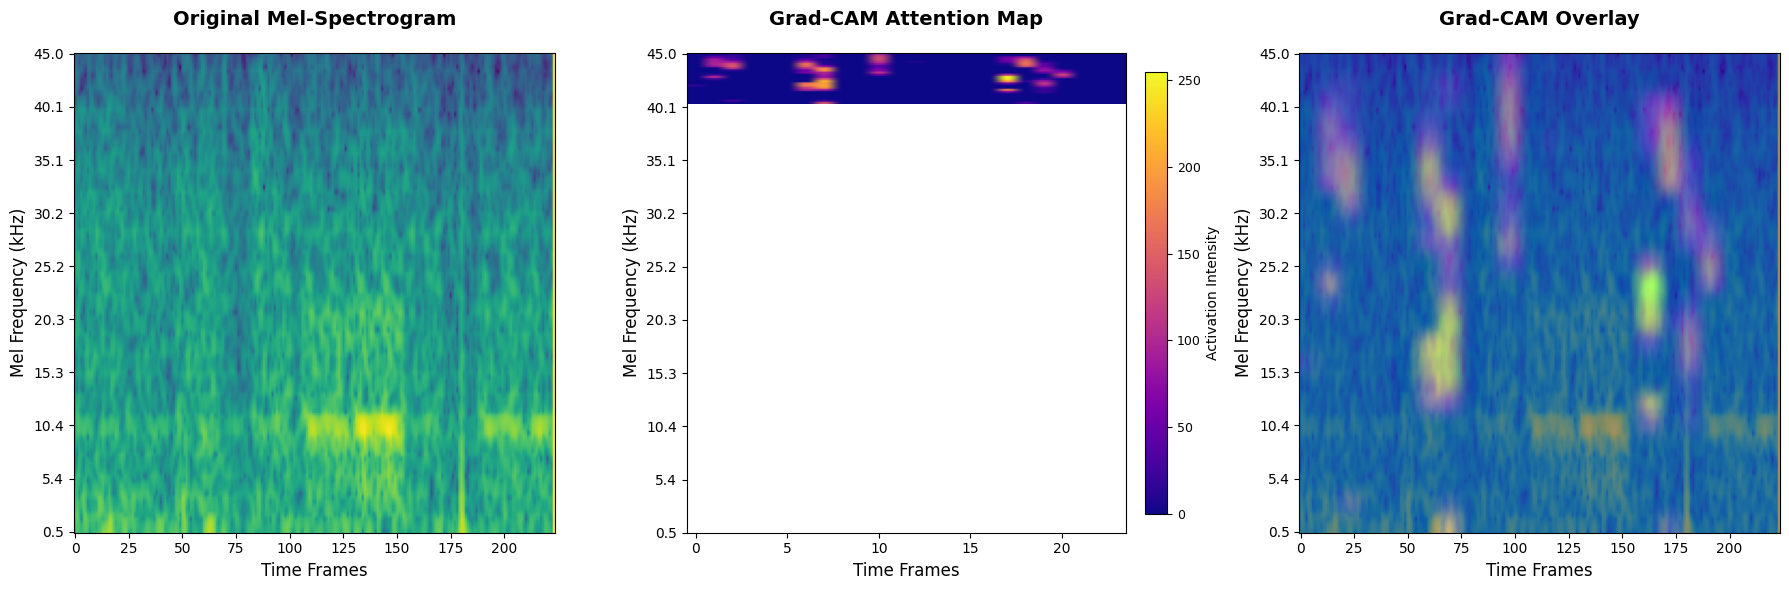

In [14]:
# Part 11: Enhanced Grad-CAM analysis with better visualization
print('------------------------------------------------------------------------')
print('Applying Enhanced Grad-CAM visualization...')

# Load the trained model
model = load_model(filepath)

# Make sure model is built by making a prediction
test_prediction = model.predict(x_test[:1])
print("Model loaded and tested successfully")

# Find the last convolutional layer name
conv_layer_names = []
for i, layer in enumerate(model.layers):
    if isinstance(layer, Conv2D):
        conv_layer_names.append(layer.name)
        print(f"Conv layer {i}: {layer.name}")

# Use the last convolutional layer
last_conv_layer_name = conv_layer_names[-1]
print(f"Using last conv layer: {last_conv_layer_name}")

# Get sample images from each class for Grad-CAM
schizophrenia_indices = [i for i, label in enumerate(y) if label == 0]  # Assuming 0 is schizophrenia
healthy_indices = [i for i, label in enumerate(y) if label == 1]       # Assuming 1 is healthy

# Take first sample from schizophrenia class
sample_schiz_idx = schizophrenia_indices[0]
sample_schiz_img = X[sample_schiz_idx:sample_schiz_idx+1]
sample_schiz_path = paths[sample_schiz_idx]

print(f"Analyzing Schizophrenia sample: {sample_schiz_path}")

# Generate Grad-CAM heatmap for schizophrenia sample
heatmap_schiz = make_gradcam_heatmap(sample_schiz_img, model, last_conv_layer_name)

# Display enhanced Grad-CAM for schizophrenia sample with plasma colormap (best for papers)
print("Enhanced Grad-CAM visualization for Schizophrenia sample (Plasma colormap):")
save_and_display_gradcam_enhanced(sample_schiz_path, heatmap_schiz, alpha=0.5,
                                colormap='plasma',
                                save_path=f"f:/SD14/plot/new/SD_81/Dataset1/Grad/full/image2/s.png")

# Show colormap comparison
print("Colormap comparison for Schizophrenia sample:")
save_and_display_gradcam_alternative_colors(sample_schiz_path, heatmap_schiz,
                                          save_path=f"f:/SD14/plot/new/SD_81/Dataset1/Grad/full/image/s_comparison.png")

# Get model prediction for this sample
prediction_schiz = model.predict(sample_schiz_img)
predicted_class_schiz = np.argmax(prediction_schiz[0])
confidence_schiz = np.max(prediction_schiz[0])

print(f"Model prediction for Schizophrenia sample:")
print(f"Predicted class: {'Schizophrenia' if predicted_class_schiz == 0 else 'Healthy'}")
print(f"Confidence: {confidence_schiz:.4f}")
print(f"Prediction probabilities: Schizophrenia={prediction_schiz[0][0]:.4f}, Healthy={prediction_schiz[0][1]:.4f}")

print('------------------------------------------------------------------------')


Analyzing Healthy sample: D:/Milon2/28_256_D1/Full\Schizophrenia\SZ_Full_patient_SZ_01_segment_000_STFT.png
Enhanced Grad-CAM visualization for Healthy sample (Plasma colormap):


C:\Users\Milon\AppData\Local\Temp\ipykernel_12504\1536394075.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colormap)


FileNotFoundError: [Errno 2] No such file or directory: 'f:/SD14/plot/new/SD_81/Dataset1/Grad/full/image2/h.png'

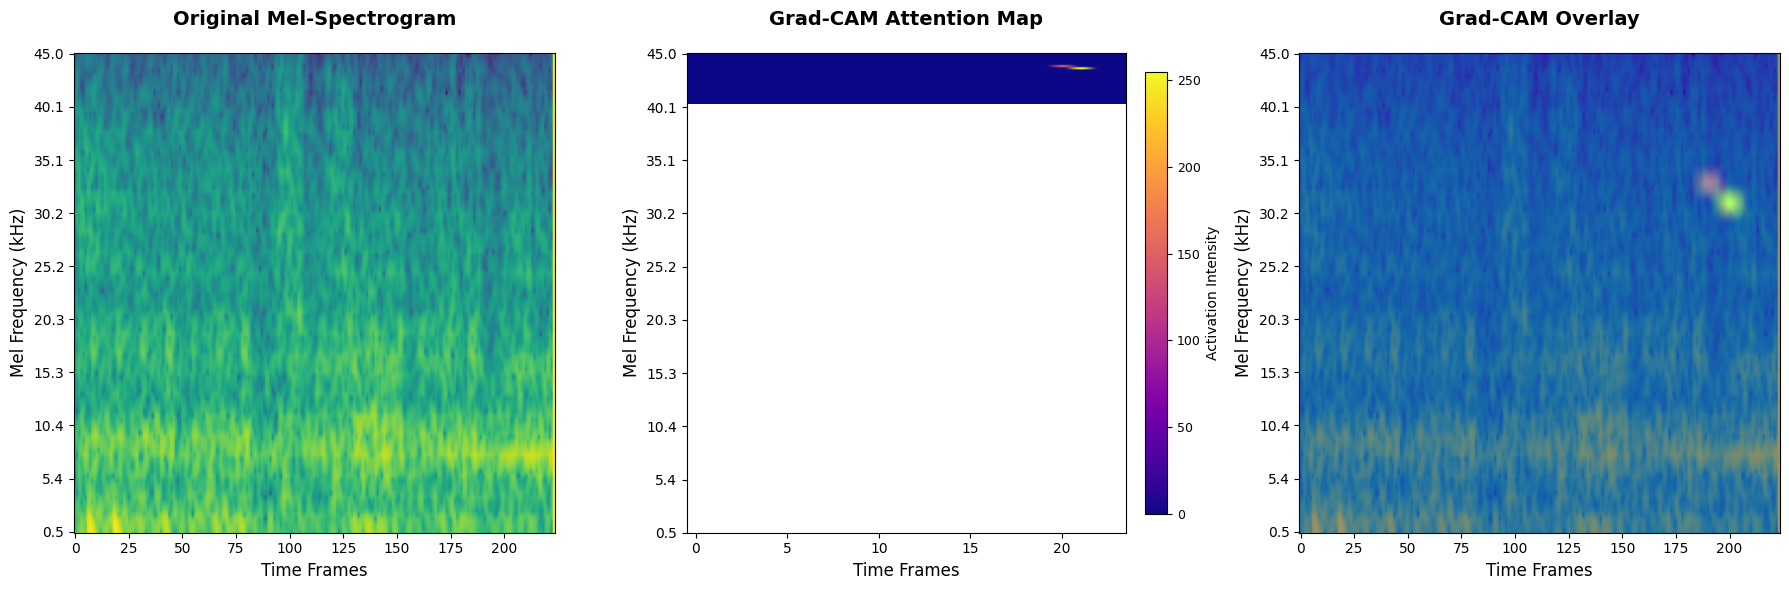

In [15]:
# Part 12: Additional analysis for healthy samples
# Take first sample from healthy class
sample_healthy_idx = healthy_indices[0]
sample_healthy_img = X[sample_healthy_idx:sample_healthy_idx+1]
sample_healthy_path = paths[sample_healthy_idx]

print(f"Analyzing Healthy sample: {sample_healthy_path}")

# Generate Grad-CAM heatmap for healthy sample
heatmap_healthy = make_gradcam_heatmap(sample_healthy_img, model, last_conv_layer_name)

# Display enhanced Grad-CAM for healthy sample
print("Enhanced Grad-CAM visualization for Healthy sample (Plasma colormap):")
save_and_display_gradcam_enhanced(sample_healthy_path, heatmap_healthy, alpha=0.5,
                                colormap='plasma',
                                save_path=f"f:/SD14/plot/new/SD_81/Dataset1/Grad/full/image2/h.png")

# Get model prediction for this sample
prediction_healthy = model.predict(sample_healthy_img)
predicted_class_healthy = np.argmax(prediction_healthy[0])
confidence_healthy = np.max(prediction_healthy[0])

print(f"Model prediction for Healthy sample:")
print(f"Predicted class: {'Schizophrenia' if predicted_class_healthy == 0 else 'Healthy'}")
print(f"Confidence: {confidence_healthy:.4f}")
print(f"Prediction probabilities: Schizophrenia={prediction_healthy[0][0]:.4f}, Healthy={prediction_healthy[0][1]:.4f}")

print('------------------------------------------------------------------------')
print('Enhanced Grad-CAM analysis completed.')

Creating publication-ready individual figures...


C:\Users\Milon\AppData\Local\Temp\ipykernel_12504\1987257299.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


FileNotFoundError: [Errno 2] No such file or directory: 'f:/SD14/plot/new/SD_81/Dataset1/Grad/full/image2/schizophrenia_gradcam_pub.png'

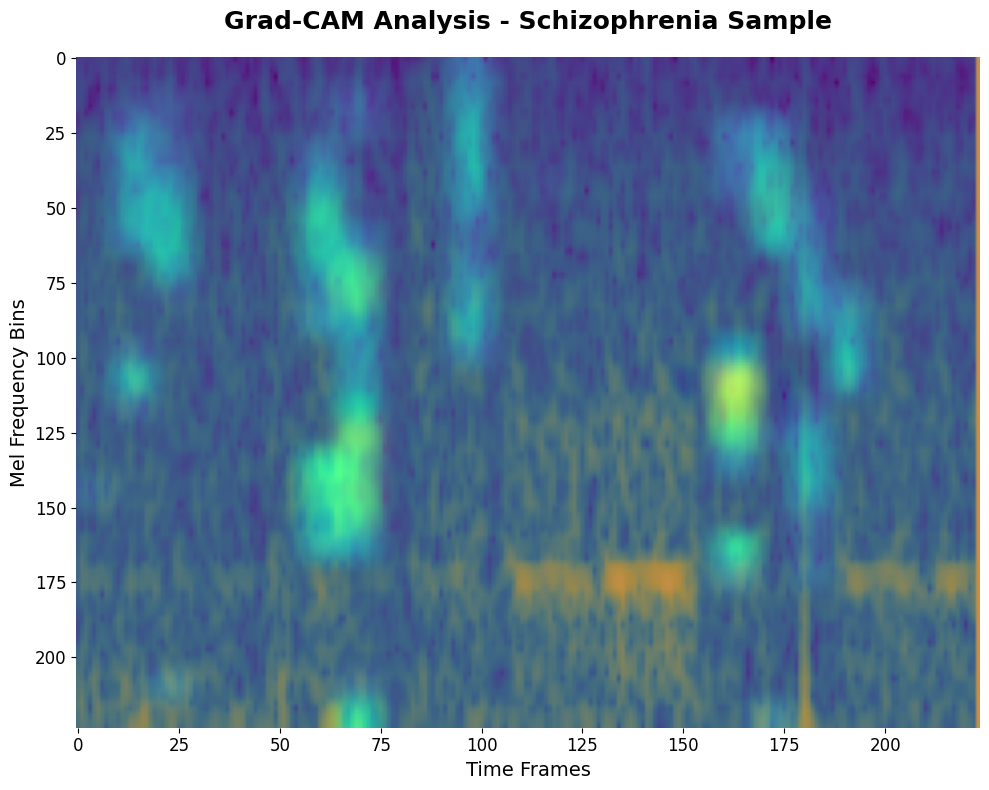

In [16]:
# Part 13: Publication-ready single visualization function
def create_publication_gradcam(img_path, heatmap, save_path, title_suffix="", alpha=0.5):
    """
    Create a single, publication-ready Grad-CAM visualization
    """
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    
    # Rescale heatmap
    heatmap_norm = np.uint8(255 * heatmap)
    
    # Use plasma colormap (best for accessibility and printing)
    cmap = plt.cm.get_cmap('viridis')
    jet_colors = cmap(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_norm]
    
    # Create overlay
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    superimposed_img = jet_heatmap * alpha + img * (1 - alpha)
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    # Create single panel figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.imshow(superimposed_img, aspect='auto')
    ax.set_title(f'Grad-CAM Analysis{title_suffix}', fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Time Frames', fontsize=14)
    ax.set_ylabel('Mel Frequency Bins', fontsize=14)
    ax.tick_params(labelsize=12)
    
    # Remove spines for cleaner look
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()

# Example usage for publication figures
print("Creating publication-ready individual figures...")
create_publication_gradcam(sample_schiz_path, heatmap_schiz, 
                          f"f:/SD14/plot/new/SD_81/Dataset1/Grad/full/image2/schizophrenia_gradcam_pub.png",
                          " - Schizophrenia Sample")

create_publication_gradcam(sample_healthy_path, heatmap_healthy,
                          f"f:/SD14/plot/new/SD_81/Dataset1/Grad/full/image2/healthy_gradcam_pub.png", 
                          " - Healthy Control Sample")